In [80]:
import os
import socket
import utils
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from utils import ext_transforms as et

DATA_DIR = {
    3 : "/mnt/server5/sdi/datasets",
    4 : "/mnt/server5/sdi/datasets",
    5 : "/data1/sdi/datasets"
}

def get_datadir():
    if socket.gethostname() == "server3":
        return DATA_DIR[3]
    elif socket.gethostname() == "server4":
        return DATA_DIR[4]
    elif socket.gethostname() == "server5":
        return DATA_DIR[5]
    else:
        raise NotImplementedError

def get_interval(image, result, mean, sigma):

    if mean - sigma > 0:
        result[(image > mean-sigma) * (image < mean+sigma)] = int(mean)
        get_interval(image, result, mean - 2*sigma, sigma)
    else:
        result[(image > mean-sigma) * (image < mean+sigma)] = 0
    return result

def get_up_interval(image, result, mean, sigma):

    if mean + sigma <= 255:
        result[(image > mean-sigma) * (image < mean+sigma)] = int(mean)
        get_up_interval(image, result, mean + 2*sigma, sigma)
    else:
        result[(image > mean-sigma) * (image < mean+sigma)] = 255
    return result

def gaussian(x, mean, var, pi = 1):
    return pi * (1 / np.sqrt(2*np.pi * var)) * np.exp(- (x-mean)**2 / (2*var))

def plot_normal(simg, mean, sigma):
    print(f'Len: {len(simg)}, mean: {mean:.4f}, sigma: {sigma:.4f}')
    x = np.arange(0, 256, 1)
    var = sigma**2
    legend = []
    plt.axvspan(mean - sigma, mean + sigma, facecolor='gray', alpha=0.5)
    plt.plot(x, gaussian(x, mean, var), color='blue')
    legend.append(f'N({mean:.2f}, {var:.2f})')
    plt.hist(simg, bins=[i for i in range(256)], density=True, color='salmon')
    legend.append('hist')
    plt.legend(legend)
    plt.show()

def hist_intersection(hist1, hist2):
    intsc = np.array([0 for i in range(256)], dtype='float32')
    for i in range(255):
        intsc[i] += min(hist1[i], hist2[i])
    return intsc.sum()

In [83]:
datadir = os.path.join(get_datadir(), 'CPN_all/Images')
maskdir = os.path.join(get_datadir(), 'CPN_all/Masks')
area = []

for fname in os.listdir(datadir):
    #print(f'Current image: {fname}')
    mname = fname.split('.')[0] + "_mask." + fname.split('.')[-1]
    mask = os.path.join(maskdir, mname)
    image = os.path.join('/data1/sdi/datasets/CPN_all/Images', fname)
    
    if not os.path.exists(mask) or not os.path.exists(image):
        raise Exception ("File Not Exists", mask, image)
    
    image = Image.open(image).convert("L")
    mask = Image.open(mask).convert("L")

    rimage = np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)]

    if rimage.ndim != 1:
        raise Exception ("dimensions are not correct", rimage.shape)

    mu = rimage.mean()
    sigma = rimage.std()

    #plot_normal(rimage, mu, sigma)

    x = np.arange(0, 256, 1)
    gau = gaussian(x, mean=mu, var=sigma)
    hist = np.array([0 for i in range(256)], dtype='float32')
    for i in range(len(rimage)):
        hist[rimage[i]] += 1
        
    area.append(hist_intersection(gau, hist))
    #print(f'area: {hist_intersection(gau, hist):.8f}')
    
    #result = get_interval(np.array(image, dtype=np.uint8), np.zeros_like(np.array(image, dtype=np.uint8)), mu, sigma)
    #result = Image.fromarray(get_up_interval(np.array(image, dtype=np.uint8), result, mu, sigma))
    #result.save(os.path.join(get_datadir(), 'CPN_all_gmm/1sigma', fname, ))

sum: 0.9999999403953552
255
0.7661015


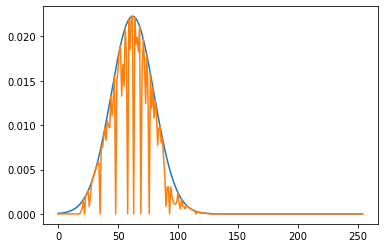

In [66]:
x = np.arange(0, 255, 1)
gau = gaussian(x, mean=62.15, var=17.91**2)
hist = np.array([0 for i in range(255)], dtype='float32')
intsc = np.array([0 for i in range(255)], dtype='float32')

for i in range(len(rimage)):
    hist[rimage[i]] += 1

hist = hist/len(rimage)

for i in range(255):
    intsc[i] += min(gau[i], hist[i])
    
#plt.plot(x, hist)
plt.plot(x, gau)
plt.plot(x, intsc)
print(f'sum: {(hist).sum()}')
print(len(intsc))
print(intsc.sum())

In [ ]:
def hist_intersection(hist1, hist2):
    intsc = np.array([0 for i in range(255)], dtype='float32')
    for i in range(255):
        intsc[i] += min(gau[i], hist[i])
    return intsc.sum()

In [86]:
area_np = np.array(area)
print(f'mean: {area_np.mean():.8f} std: {area_np.std():.8f}')

mean: 0.90642661 std: 0.04953310


In [116]:
datadir = os.path.join(get_datadir(), 'CPN_all/Images')
maskdir = os.path.join(get_datadir(), 'CPN_all/Masks')

for fname in os.listdir(datadir):
    #print(f'Current image: {fname}')
    mname = fname.split('.')[0] + "_mask." + fname.split('.')[-1]
    mask = os.path.join(maskdir, mname)
    image = os.path.join('/data1/sdi/datasets/CPN_all/Images', fname)
    
    if not os.path.exists(mask) or not os.path.exists(image):
        raise Exception ("File Not Exists", mask, image)
    
    image = Image.open(image).convert("L")
    mask = Image.open(mask).convert("L")

    rimage = np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)]

    if rimage.ndim != 1:
        raise Exception ("dimensions are not correct", rimage.shape)

    mu = rimage.mean()
    sigma = rimage.std()
    print(f'mean: {mu:.8f}, std: {sigma:.8f}')
    lwimage = np.array(image, dtype=np.uint8) >= (mu - sigma)
    upimage = np.array(image, dtype=np.uint8) <= (mu + sigma)
    rimage = lwimage * upimage
    result = np.where(rimage == False, rimage, 255).astype(np.uint8)
    result = Image.fromarray(rimage, )
    result.save(os.path.join(get_datadir(), 'CPN_pseudo/Masks', mname, ))
    #plt.imshow(result, cmap='gray')
    '''plt.figure()
    plt.imshow(rimage, cmap='gray')
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.figure()
    plt.imshow(image, cmap='gray')'''
    
    #result = get_interval(np.array(image, dtype=np.uint8), np.zeros_like(np.array(image, dtype=np.uint8)), mu, sigma)
    #result = Image.fromarray(get_up_interval(np.array(image, dtype=np.uint8), result, mu, sigma))
    #result.save(os.path.join(get_datadir(), 'CPN_all_gmm/1sigma', fname, ))

mean: 62.15929204, std: 17.91026866
mean: 35.57827532, std: 18.92640720
mean: 93.94208675, std: 28.17399754
mean: 54.28486196, std: 16.82830999
mean: 75.16836355, std: 25.81052548
mean: 82.49232159, std: 20.51541568
mean: 45.76692708, std: 18.35518631
mean: 47.54362338, std: 23.79769544
mean: 83.59508746, std: 14.97430444
mean: 84.05911017, std: 25.60738650
mean: 35.35847695, std: 24.75544697
mean: 46.67301906, std: 11.98386038
mean: 83.49421894, std: 25.55236821
mean: 99.75627590, std: 26.43663196
mean: 72.32027080, std: 19.63949314
mean: 99.40285500, std: 30.21719759
mean: 90.15237508, std: 24.05997925
mean: 72.43204420, std: 17.58898672
mean: 72.32078800, std: 20.49072351
mean: 83.02406577, std: 20.64562236
mean: 67.55411255, std: 14.96780341
mean: 53.70702882, std: 20.21136001
mean: 85.80634423, std: 27.23010561
mean: 67.64500118, std: 21.81628559
mean: 55.95243978, std: 20.17664943
mean: 54.34616608, std: 28.88292148
mean: 127.32887253, std: 23.45254755
mean: 63.62738550, std: 29.

In [122]:
a = [1, 2, 3]
a[0:1] + a[0:1]
len(a)

3